# Irradiated Monkeys
This data anlysis attempts to aply machine learning concepts to analyze the patterns and make predictions related to Rhesus monkeys housed by Wake Forest University and in collaboration with Dr. Thomas Johnson of Colorado State University and Dr. Susan Bailey of Colorado Atate Uiversity. The monkeys were irradiated with differnt doses, types, and frequencies of radiation, and blood analytics were frequently measured after radiation. The health records of the monkeys were also recorded, and all monkeys that aare iving are still being monitored. Thus, in this notebook I will test the following:
- 1.) Can machine learning cluster patterns in monkey response to radiation?
- 2.) Can machine learning make accurate blood analytic predicitons?
- 3.) Can machine learning predict the health statuses of the monkeys?
- 4.) What features contribute most to the end biomarker and prognostic statuses of the monkeys? 

# Data handling

In [1]:
# handling data
import pandas as pd
import numpy as np
import datetime

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Statistics
from scipy import stats
#import statsmodels.api as sm
import statsmodels.imputation.mice as smi
import scipy.cluster.hierarchy as hac
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.gridspec as gridspec
import math
import random


#SHAP Value stuff
import shap
from shap import TreeExplainer
from shap import GradientExplainer
from shap import DeepExplainer
from shap import KernelExplainer
from shap import SamplingExplainer
from shap import PartitionExplainer

#ML stuff
import catboost
from catboost import CatBoostClassifier, Pool, CatBoostRegressor, CatBoost

#language handling
#import bert


#from mxnet import nd, autograd, gluon
#from mxnet.gluon import nn, rnn
#import mxnet as mx


print("Setup Complete")

Setup Complete


In [3]:
pwd

'/Users/aidanlew'

In [2]:
cd '/Users/aidanlew/Documents'

/Users/aidanlew/Documents


In [5]:
#ls

In [3]:
def parser(x):
    return datetime.datetime.strptime(x,'%d-%m-%y')

In [27]:
#Makee a df were all the data is present (except irrad data for the controls)
solid_monkey_df = pd.read_excel('../Documents/full_monkey_data_r2.xlsx',
                    #sheet_name=1,
                    skiprows = 0,
                    usecols = ['ID', 'Species', 'SAMPLE_DATE', 'IRRAD ', 'IRRAD_DATE', 'DOSE_(Gy)',
       'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD', 'DOB',
       'SEX', 'AGE', 'TYPE', 'WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
                    engine = 'openpyxl',
                    date_parser=parser
                         )

#Set the index to the monkey ID and make the labels not read as integers
solid_monkey_df.set_index(['ID'])
solid_monkey_df['ID'] = solid_monkey_df['ID'].astype(str)
#solid_monkey_df.dropna(axis=0, inplace=True) 

#x = solid_monkey_df.columns
solid_monkey_df.tail()

Cannot parse header or footer so it will be ignored


,ID,Species,SAMPLE_DATE,IRRAD,IRRAD_DATE,DOSE_(Gy),DAYS_SINCE_IRRAD,MONTHS_SINCE_IRRAD,MONTHS AT IRRAD,DOB,...,LYMPHOCYTES_(%),MONO_(%),EOS_(%),BASO_(%),ABS_NEUT_(/uL),ABS_LYMPH_(/uL),ABS_MONO_(/uL),ABS_EOS_(/uL),ABS_BASO_(/uL),PLATLET_COUNT_(K/uL)
4547,2112,Rhesus-Chinese,2020-09-23 00:00:00,No,NaT,NaN,NaN,NaN,NaN,1999-09-28,...,67.0,6.2,1.1,0.0,1696,4422,409,73,0,289
4548,2112,Rhesus-Chinese,2021-03-04 00:00:00,No,NaT,NaN,NaN,NaN,NaN,1999-09-28,...,56.1,9.1,1.5,0.0,1312,2210,359,59,0,284
4549,2210,Rhesus-Indian,2021-09-07 00:00:00,No,NaT,NaN,NaN,NaN,NaN,1999-01-01,...,26.8,12.3,1.2,0.0,3104,1394,640,62,0,311
4550,2210,Rhesus-Indian,2021-09-20 00:00:00,No,NaT,NaN,NaN,NaN,NaN,1999-01-01,...,36.2,10.9,1.7,0.0,2970,2100,632,99,0,348
4551,2210,Rhesus-Indian,2021-10-07 00:00:00,No,NaT,NaN,NaN,NaN,NaN,1999-01-01,...,16.0,21.0,3.0,0.0,3360,896,1176,168,0,329


## We have 31 variables and 4551 sample dates, get stoked
May need to add some of the monkeys that had missing data, but it's robust enough at the moment


# Vizualization
    1.) See the blood analytics over time for each monkey
    2.) See the ages of the monkeys
        a.) For the absolute age
        b.) For age at irrad
        c.) For time since irrad

In [6]:
solid_monkey_df.columns

Index(['ID', 'Species', 'SAMPLE_DATE', 'IRRAD ', 'IRRAD_DATE', 'DOSE_(Gy)',
       'DAYS_SINCE_IRRAD', 'MONTHS_SINCE_IRRAD', 'MONTHS AT IRRAD', 'DOB',
       'SEX', 'AGE', 'TYPE', 'WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'],
      dtype='object')

In [ ]:
# Make a violin plot for all monkeys
sns.violinplot(data=solid_monkey_df, x="SAMPLE_DATE", y="LYMPHOCYTES_(%)", hue="ID",
               #split=True, inner="quart", linewidth=1,
               #palette={"Yes": "b", "No": ".85"}
              )
sns.despine(left=True)

In [ ]:
# Trying to viz one monkey's changes over time
sns.lineplot(x="SAMPLE_DATE", y="LYMPHOCYTES_(%)",
             hue="ID", 
             #style="event",
             data=solid_monkey_df)

<AxesSubplot:xlabel='AGE', ylabel='Count'>

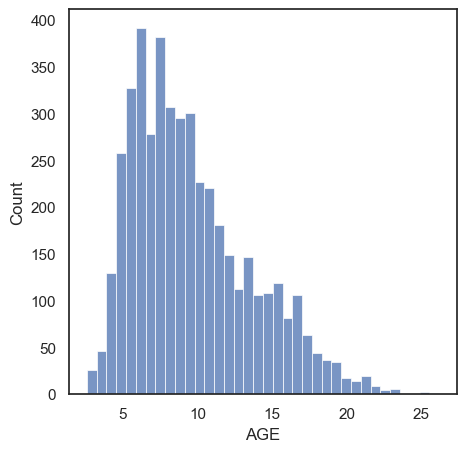

In [58]:
#See the distribution of Age
plt.figure(figsize=(5,5))

sns.histplot(
    solid_monkey_df,
    x="AGE", 
    #hue="",
    #multiple="stack",
    palette="light:m_r",
    #edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)

<AxesSubplot:xlabel='DAYS_SINCE_IRRAD', ylabel='Count'>

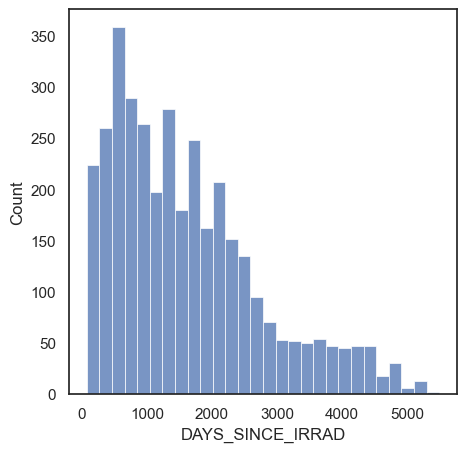

In [59]:
#See the distribution of Sample Age
plt.figure(figsize=(5,5))
sns.histplot(
    solid_monkey_df,
    x='DAYS_SINCE_IRRAD', 
    #hue="",
    #multiple="stack",
    palette="light:m_r",
    #edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)

<AxesSubplot:xlabel='MONTHS_SINCE_IRRAD', ylabel='Count'>

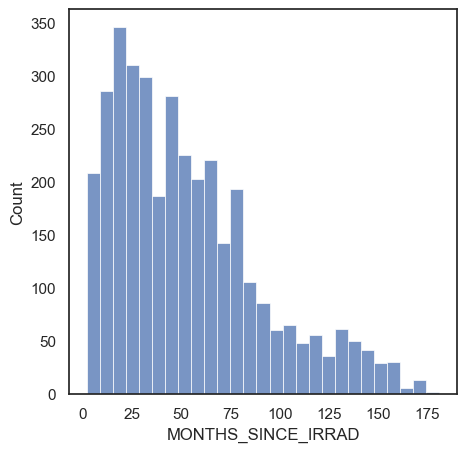

In [60]:
#See the distribution of Sample Age
plt.figure(figsize=(5,5))

sns.histplot(
    solid_monkey_df,
    x='MONTHS_SINCE_IRRAD', 
    #hue="",
    #multiple="stack",
    palette="light:m_r",
    #edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)

<AxesSubplot:xlabel='MONTHS AT IRRAD', ylabel='Count'>

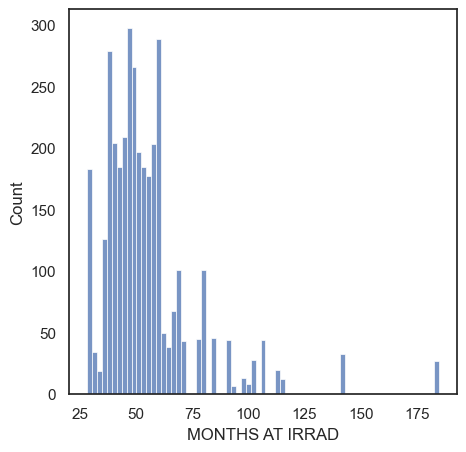

In [61]:
#See the distribution of Sample Age
plt.figure(figsize=(5,5))

sns.histplot(
    solid_monkey_df,
    x='MONTHS AT IRRAD', 
    #hue="",
    #multiple="stack",
    palette="light:m_r",
    #edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)

### Immediately there's no use in visualizing with typical plots that handle only a few variables
 - Viz with UMAP
 - Viz with other high-quantitiy plots
 - Viz with facet grids 

## UMAP
 - Cluster blood analytics
 - Cluster other stuff?
 
See the docs here: https://umap-learn.readthedocs.io/en/latest/index.html



### Blood analytic UMAP

#### Simple UMAP

In [30]:
# Same setup as from the docs example: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

import umap
reducer = umap.UMAP()


print('Setup Complete')

Setup Complete


In [36]:
#need to scale the vales to z-scores to get them all on the same page

#Make df with the blood analytics with no missing values
solid_monkey_df.copy()
blood_monkey_df = solid_monkey_df[['ID', 'WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)']].dropna()

#blood_monkey_df.head()

#Scale the blood to z-scores
blood_umap_df = blood_monkey_df[
    [
        'ID', 'WBC_(K/uL)', 'RBC_(M/uL)',
       'Hemaglobin_(HGB_g/dL)', 'Hemocrit_(HCT_%)',
       'Mean_corpuscular_volume_(MCV_fL)',
       'Mean_corpuscular_hemaglobin_(MCH_pg)',
       'Mean_corpuscular_hemaglobin_concentration_(MCHC_g/dL)', 'NEUT_(%)',
       'LYMPHOCYTES_(%)', 'MONO_(%)', 'EOS_(%)', 'BASO_(%)', 'ABS_NEUT_(/uL)',
       'ABS_LYMPH_(/uL)', 'ABS_MONO_(/uL)', 'ABS_EOS_(/uL)', 'ABS_BASO_(/uL)',
       'PLATLET_COUNT_(K/uL)'
    ]
].values
scaled_blood_df= StandardScaler().fit_transform(blood_umap_df)

In [47]:
# Want it to be (n, 2) for UMAP to work
embedding = reducer.fit_transform(scaled_blood_df)
embedding.shape

(4552, 2)

In [46]:
#Umap needs ID to be an intiger, not str
blood_monkey_df['ID'] = blood_monkey_df['ID'].astype(int)

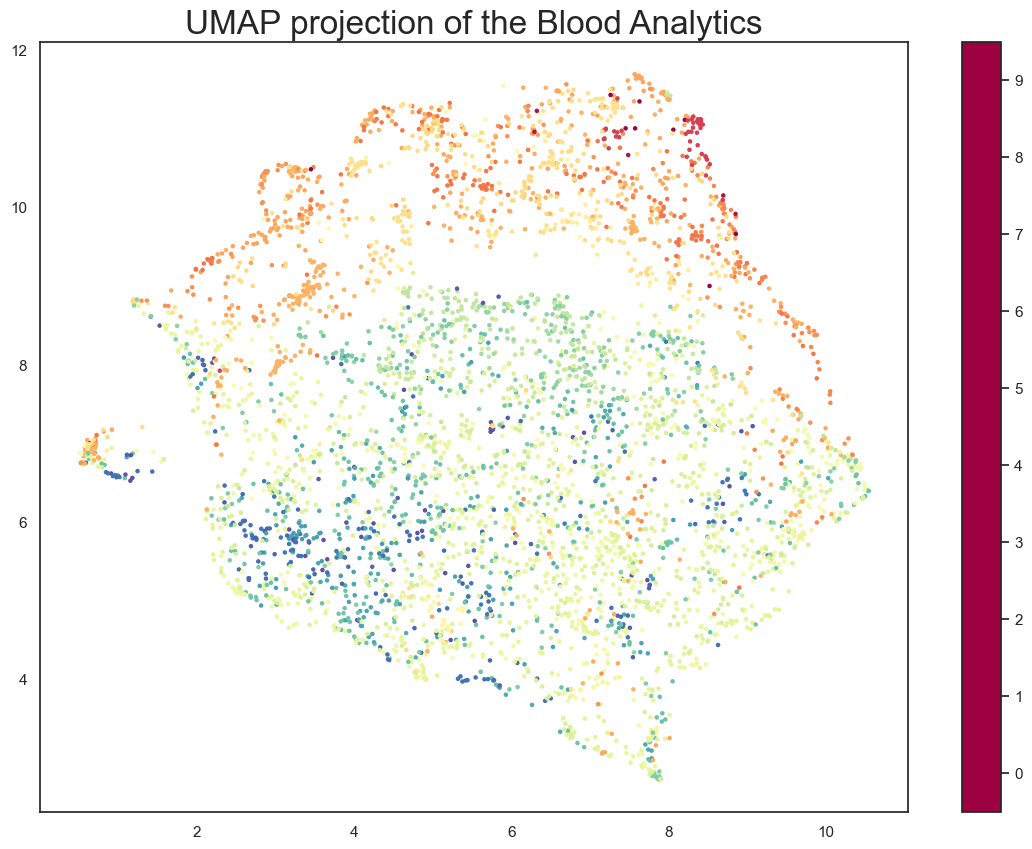

In [49]:
# Simply visualize the UMAP
plt.scatter(embedding[:, 0], 
            embedding[:, 1], 
            c=blood_monkey_df.ID, 
            cmap='Spectral', 
            s=5
           )
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Blood Analytics', fontsize=24);

#### Interactive UMAP to see the ID's for each cluster
- it looks like there are at least three different clusters, we want to know which ones are similar
- also find out how to parse them numerically

# Machine Learning Magic



## 1.) Can machine learning cluster patterns in monkey response to radiation?

## 2.) Can machine learning make accurate blood analytic predicitons?

## 3.) Can machine learning predict the health statuses of the monkeys?

## 4.) What features contribute most to the end biomarker and prognostic statuses of the monkeys?

# Conclusions